In [16]:
import pandas as pd
import mysql.connector
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Bhumika@123456789',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r"C:\Users\Asus\OneDrive\Documents\Courses\Data_Analytics\Projects_Dataset\Python+SQL+Project+Dataset\sales_dataset"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [17]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Bhumika@123456789',
    database='ecommerce'
)
cursor = conn.cursor()

##  List all Unique Cities where customers are located.

In [14]:
cursor.execute('select distinct customer_city from customers')
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Distinct Customer Cities'])
df.index = range(1, len(df)+1)
df.head()

,Distinct Customer Cities
1,franca
2,sao bernardo do campo
3,sao paulo
4,mogi das cruzes
5,campinas


In [8]:
len(df)

4119

## Count the Number of Orders placed in 2017.

In [9]:
cursor.execute('select count(order_id) from orders where year(order_purchase_timestamp) = 2017')
data = cursor.fetchall()
print('Total orders placed in 2017 are', data[0][0])

Total orders placed in 2017 are 45101


## Find Total Sales per Category.

In [21]:
querry = """select products.product_category as Category, round(sum(payments.payment_value),2) as Sales from products join order_items on 
products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id group by Category"""
cursor.execute(querry)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df.index = range(1, len(df) + 1)
df['Category'] = df['Category'].str.title()
df.head(10)

,Category,Sales
1,Perfumery,506738.66
2,Furniture Decoration,1430176.39
3,Telephony,486882.05
4,Bed Table Bath,1712553.67
5,Automotive,852294.33
6,Computer Accessories,1585330.45
7,Housewares,1094758.13
8,Babies,539845.66
9,Toys,619037.69
10,Furniture Office,646826.49


## Calculate the Percentage of Orders that were paid in installments.

In [11]:
cursor.execute('select sum(case when payment_installments >=1 then 1 else 0 end)/count(*) * 100 from payments')
data = cursor.fetchall()
print('The percentage of orders that were paid in installments are',data)

The percentage of orders that were paid in installments are [(Decimal('99.9981'),)]


## Count the number of customers from each state.

In [98]:
cursor.execute('select customer_state as States, count(customer_id) from customers group by States')
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns =  ['States', 'Number of orders'])
df.index=range(1, len(df)+1)
df

,States,Number of orders
1,SP,41746
2,SC,3637
3,MG,11635
4,PR,5045
5,RJ,12852
6,RS,5466
7,PA,975
8,GO,2020
9,ES,2033
10,BA,3380


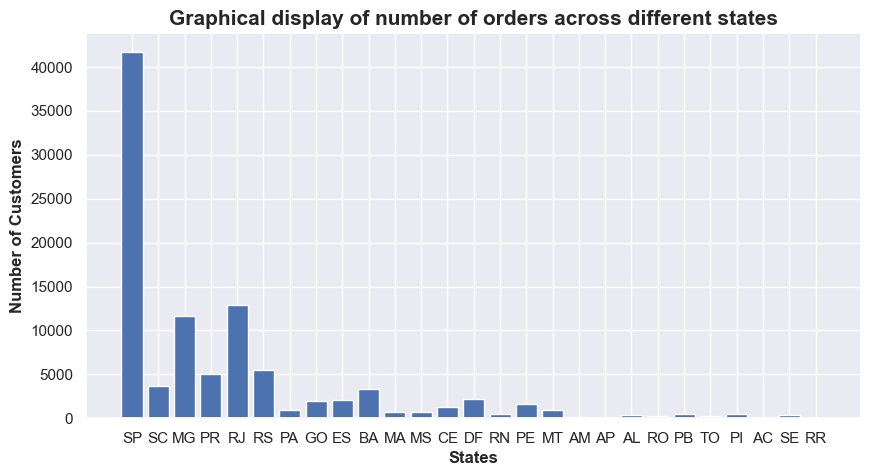

In [104]:
sns.set()
plt.figure(figsize = (10,5))
plt.title('Graphical display of number of orders across different states', fontweight = 'bold', fontsize = 15)
plt.xlabel('States', fontweight = 'bold', fontsize = 12)
plt.ylabel('Number of Customers', fontweight = 'bold', fontsize = 12)
plt.bar(df['States'], df['Number of orders'])
#plt.xticks(rotation = 30)
plt.show()

## Calculate the number of orders per month in 2018.

In [75]:
cursor.execute('select monthname(order_purchase_timestamp) as Months, count(order_id) from orders where year(order_purchase_timestamp) = 2018 group by Months')
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Month Name', 'Number of Orders'])
df.index =range(1, len(df)+1)
df

,Month Name,Number of Orders
1,July,6292
2,August,6512
3,February,6728
4,June,6167
5,March,7211
6,January,7269
7,May,6873
8,April,6939
9,September,16
10,October,4


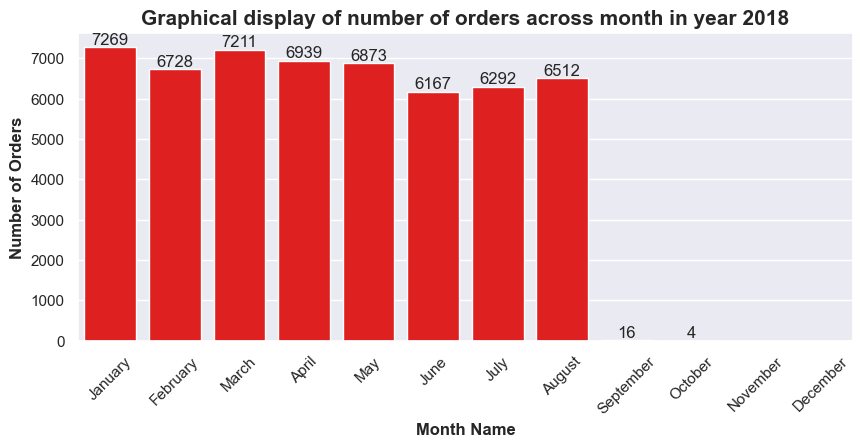

In [89]:
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(10,4))
ax = sns.barplot(x = df['Month Name'], y= df['Number of Orders'], data = df, order = o, color = 'red')
plt.title('Graphical display of number of orders across month in year 2018', fontweight = 'bold', fontsize = 15)
plt.xlabel('Month Name', fontweight = 'bold', fontsize = 12)
plt.ylabel('Number of Orders', fontweight = 'bold', fontsize = 12)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

## Find average number of products per order grouped by city.

In [72]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc from orders join order_items 
on orders.order_id = order_items.order_id  group by orders.order_id, orders.customer_id) select customers.customer_city, round(avg(count_per_order.oc)
,2)  as `Average Orders` from customers join count_per_order on customers.customer_id = count_per_order.customer_id group by customers.customer_city"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns= ['Customer City','Average Orders'])
df['Customer City'] = df['Customer City'].str.title()
df.index=range(1,len(df)+1)
df

,Customer City,Average Orders
1,Sao Paulo,1.16
2,Sao Jose Dos Campos,1.14
3,Porto Alegre,1.17
4,Indaial,1.12
5,Treze Tilias,1.27
...,...,...
4106,Japaratuba,1.00
4107,Sebastiao Leal,1.00
4108,Buriti,3.00
4109,Morro Agudo De Goias,1.00


## Calculate the percentage of total revenue contributed by each product category.

In [56]:
querry = """SELECT products.product_category AS Category, ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS Sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id 
JOIN payments ON payments.order_id = order_items.order_id 
GROUP BY Category 
ORDER BY Sales DESC;
"""
cursor.execute(querry)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Category', 'Percentage_of_revenue'])
df['Category']= df['Category'].str.title()
df.index=range(1,len(df)+1)
df

,Category,Percentage_of_revenue
1,Bed Table Bath,10.70
2,Health Beauty,10.35
3,Computer Accessories,9.90
4,Furniture Decoration,8.93
5,Watches Present,8.93
...,...,...
70,House Comfort 2,0.01
71,Cds Music Dvds,0.01
72,Pc Gamer,0.01
73,Fashion Children'S Clothing,0.00


## Identify the correlation between product price and the number of times a product has been purchased.

In [68]:
query = """ select products.product_category, count(order_items.product_id), round(avg(order_items.price),2) 
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category
"""

cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Product_Category','Number Of Orders','Price'])
df.index=range(1,len(df)+1)
arr1 = df['Number Of Orders']
arr2 = df['Price']
a = np.corrcoef(arr1, arr2)
print('The correlation between product price and the number of times a product has been purchased is', a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


## Calculate the total revenue generated by each seller and rank them by revenue.

In [4]:
query = """select*, rank() over(order by Revenue desc) from (select order_items.seller_id, sum(payments.payment_value)as Revenue from 
order_items join payments on order_items.order_id = payments.order_id group by order_items.seller_id) as a
"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Sellers_Id', 'Revenue', 'Rank'])
df.index=range(1,len(df)+1)
df.head()

,Sellers_Id,Revenue,Rank
1,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
2,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
3,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
4,1f50f920176fa81dab994f9023523100,290253.420128,4
5,53243585a1d6dc2643021fd1853d8905,284903.080498,5


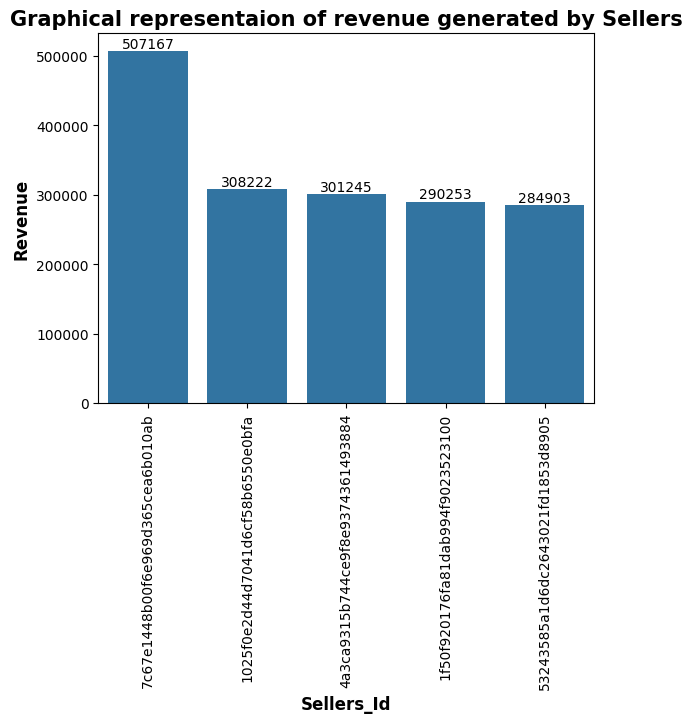

In [7]:
df = df.head()
ax = sns.barplot(x = df['Sellers_Id'], y = df['Revenue'])
ax.bar_label(ax.containers[0])
plt.title('Graphical representaion of revenue generated by Sellers', fontweight = 'bold', fontsize = 15)
plt.xlabel('Sellers_Id', fontweight = 'bold', fontsize = 12)
plt.ylabel('Revenue', fontweight = 'bold', fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

## Calculate the moving average order values for each customer over their order history.

In [19]:
querry = """ select Customers_Id, Purchase_Timestamp, Payments, avg(payments) over (partition by Customers_Id order by Purchase_Timestamp rows 
between 2 preceding and current row) as Moving_Averagge from  (select orders.customer_id as Customers_Id, orders.order_purchase_timestamp as Purchase_Timestamp, 
payments.payment_value as payments from payments join orders on payments.order_id = orders.order_id) as a
"""
cursor.execute(querry)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns = ['Customers_Id','Purchase_Timestamp', 'Payments', 'Moving_Average'])
df.index= range(1, len(df)+1)
df

,Customers_Id,Purchase_Timestamp,Payments,Moving_Average
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
4,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
5,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103882,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103883,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103884,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103885,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


## Calculate the cumulative sales per month for each year.

In [35]:
query = """select Years, Month, Payments, sum(Payments) over (order by Years, Month) as Cumulative_Sales from (
select year(orders.order_purchase_timestamp) as Years, month(orders.order_purchase_timestamp) as Month, round(sum(payments.payment_value),2)
as Payments from orders join payments on orders.order_id = payments.order_id  group by Years, Month order by Years, Month) as a"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Years', 'Month', 'Cumulative_Sales','Payments'])
df.index=range(1, len(df)+1)
df

,Years,Month,Cumulative_Sales,Payments
1,2016,9,252.24,252.24
2,2016,10,59090.48,59342.72
3,2016,12,19.62,59362.34
4,2017,1,138488.04,197850.38
5,2017,2,291908.01,489758.39
6,2017,3,449863.60,939621.99
7,2017,4,417788.03,1357410.02
8,2017,5,592918.82,1950328.84
9,2017,6,511276.38,2461605.22
10,2017,7,592382.92,3053988.14


## Calculate year-over-year growth rate of total sales.

In [23]:
query = """with a as (select year(orders.order_purchase_timestamp) as Years, round(sum(payments.payment_value),2) as Sales from orders 
join payments on orders.order_id = payments.order_id  group by Years order by years)
select Years, Sales, ((Sales - lag(Sales, 1) over (order by Years))/lag(Sales, 1) over (order by Years))*100 from a
"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Year','Sales', 'Growth Rate'])
df.index=range(1,len(df)+1)
df

,Year,Sales,Growth Rate
1,2016,59362.34,NaN
2,2017,7249746.73,12112.703761
3,2018,8699763.05,20.000924


## Identify the top 3 customers who spend the most money in each year.

In [59]:
query = """select Year,Customer_Id, Spending, d_rank  from (select year(orders.order_purchase_timestamp) as Year, orders.customer_id as Customer_Id, sum(payments.payment_value) as Spending, 
dense_rank() over ( partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank from orders join payments on orders.order_id = payments.order_id group by 
year(orders.order_purchase_timestamp), Customer_Id) as a where d_rank<=3
"""
cursor.execute(query)
data = cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Year', 'Customer_Id', 'Spending', 'Rank'])
df.index=range(1,len(df)+1)
df

,Year,Customer_Id,Spending,Rank
1,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
2,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
3,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
4,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
5,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
6,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
7,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
8,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
9,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


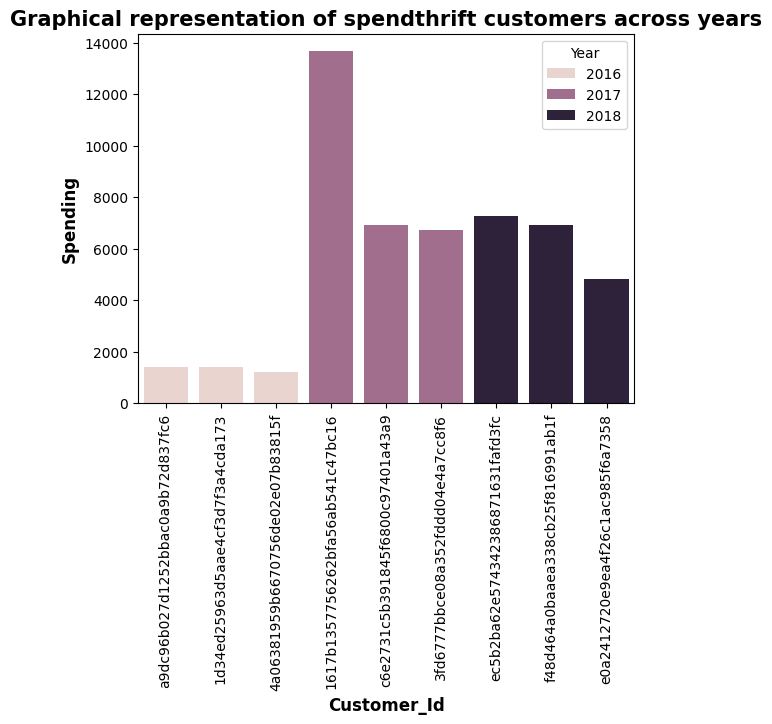

In [66]:
sns.barplot(x = df['Customer_Id'], y = df['Spending'], data = df, hue = df['Year'])
plt.title('Graphical representation of spendthrift customers across years', fontsize  = 15, fontweight='bold')
plt.xlabel('Customer_Id', fontsize = 12, fontweight = 'bold')
plt.ylabel('Spending', fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()